In [1]:
import sys
sys.path.append('../src/gnn_tracking')
from preprocessing.point_cloud_builder import PointCloudBuilder

/home/jdezoort/.conda/envs/pyg2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pc_builder = PointCloudBuilder(indir='/tigress/jdezoort/codalab/train_1', outdir='../point_clouds/',
                            n_sectors=64, pixel_only=True, redo=True, measurement_mode=False)
pc_builder.process(n=1, verbose=False)
pc_builder.data_list

Processing /tigress/jdezoort/codalab/train_1/event000021289
Output statistics: {'n_hits': 66231, 'n_particles': 9835, 'n_noise': 3752, 'n_sector_hits': 83965, 'n_sector_particles': 21038}


[Data(x=[1326, 7], particle_id=[1326], pt=[1326]),
 Data(x=[1391, 7], particle_id=[1391], pt=[1391]),
 Data(x=[1310, 7], particle_id=[1310], pt=[1310]),
 Data(x=[1285, 7], particle_id=[1285], pt=[1285]),
 Data(x=[1465, 7], particle_id=[1465], pt=[1465]),
 Data(x=[1256, 7], particle_id=[1256], pt=[1256]),
 Data(x=[1302, 7], particle_id=[1302], pt=[1302]),
 Data(x=[1295, 7], particle_id=[1295], pt=[1295]),
 Data(x=[1387, 7], particle_id=[1387], pt=[1387]),
 Data(x=[1185, 7], particle_id=[1185], pt=[1185]),
 Data(x=[1332, 7], particle_id=[1332], pt=[1332]),
 Data(x=[1235, 7], particle_id=[1235], pt=[1235]),
 Data(x=[1340, 7], particle_id=[1340], pt=[1340]),
 Data(x=[1225, 7], particle_id=[1225], pt=[1225]),
 Data(x=[1385, 7], particle_id=[1385], pt=[1385]),
 Data(x=[1205, 7], particle_id=[1205], pt=[1205]),
 Data(x=[1393, 7], particle_id=[1393], pt=[1393]),
 Data(x=[1281, 7], particle_id=[1281], pt=[1281]),
 Data(x=[1347, 7], particle_id=[1347], pt=[1347]),
 Data(x=[1228, 7], particle_id=

In [3]:
from graph_construction.graph_builder import GraphBuilder
graph_builder = GraphBuilder('../point_clouds/', '../graphs', redo=True)
graph_builder.process(verbose=True)
graph_builder.data_list

Processing data21289_s19.pt
Data(x=[1228, 7], particle_id=[1228], pt=[1228], edge_index=[2, 12943], edge_attr=[4, 12943], y=[12943])
Writing ../graphs/data21289_s19.pt
Processing data21289_s14.pt
Data(x=[1385, 7], particle_id=[1385], pt=[1385], edge_index=[2, 20604], edge_attr=[4, 20604], y=[20604])
Writing ../graphs/data21289_s14.pt
Processing data21289_s36.pt
Data(x=[1327, 7], particle_id=[1327], pt=[1327], edge_index=[2, 23435], edge_attr=[4, 23435], y=[23435])
Writing ../graphs/data21289_s36.pt
Processing data21289_s20.pt
Data(x=[1368, 7], particle_id=[1368], pt=[1368], edge_index=[2, 25197], edge_attr=[4, 25197], y=[25197])
Writing ../graphs/data21289_s20.pt
Processing data21289_s40.pt
Data(x=[1329, 7], particle_id=[1329], pt=[1329], edge_index=[2, 16227], edge_attr=[4, 16227], y=[16227])
Writing ../graphs/data21289_s40.pt
Processing data21289_s48.pt
Data(x=[1403, 7], particle_id=[1403], pt=[1403], edge_index=[2, 24312], edge_attr=[4, 24312], y=[24312])
Writing ../graphs/data21289

Data(x=[1176, 7], particle_id=[1176], pt=[1176], edge_index=[2, 13037], edge_attr=[4, 13037], y=[13037])
Writing ../graphs/data21289_s63.pt
Processing data21289_s39.pt
Data(x=[1333, 7], particle_id=[1333], pt=[1333], edge_index=[2, 12833], edge_attr=[4, 12833], y=[12833])
Writing ../graphs/data21289_s39.pt
Processing data21289_s23.pt
Data(x=[1392, 7], particle_id=[1392], pt=[1392], edge_index=[2, 12547], edge_attr=[4, 12547], y=[12547])
Writing ../graphs/data21289_s23.pt
Processing data21289_s35.pt
Data(x=[1189, 7], particle_id=[1189], pt=[1189], edge_index=[2, 14501], edge_attr=[4, 14501], y=[14501])
Writing ../graphs/data21289_s35.pt
Processing data21289_s32.pt
Data(x=[1293, 7], particle_id=[1293], pt=[1293], edge_index=[2, 20375], edge_attr=[4, 20375], y=[20375])
Writing ../graphs/data21289_s32.pt
Processing data21289_s24.pt
Data(x=[1459, 7], particle_id=[1459], pt=[1459], edge_index=[2, 22325], edge_attr=[4, 22325], y=[22325])
Writing ../graphs/data21289_s24.pt
Processing data21289

{'data21289_s19.pt': Data(x=[1228, 7], particle_id=[1228], pt=[1228], edge_index=[2, 12943], edge_attr=[4, 12943], y=[12943]),
 'data21289_s14.pt': Data(x=[1385, 7], particle_id=[1385], pt=[1385], edge_index=[2, 20604], edge_attr=[4, 20604], y=[20604]),
 'data21289_s36.pt': Data(x=[1327, 7], particle_id=[1327], pt=[1327], edge_index=[2, 23435], edge_attr=[4, 23435], y=[23435]),
 'data21289_s20.pt': Data(x=[1368, 7], particle_id=[1368], pt=[1368], edge_index=[2, 25197], edge_attr=[4, 25197], y=[25197]),
 'data21289_s40.pt': Data(x=[1329, 7], particle_id=[1329], pt=[1329], edge_index=[2, 16227], edge_attr=[4, 16227], y=[16227]),
 'data21289_s48.pt': Data(x=[1403, 7], particle_id=[1403], pt=[1403], edge_index=[2, 24312], edge_attr=[4, 24312], y=[24312]),
 'data21289_s46.pt': Data(x=[1123, 7], particle_id=[1123], pt=[1123], edge_index=[2, 14511], edge_attr=[4, 14511], y=[14511]),
 'data21289_s21.pt': Data(x=[1094, 7], particle_id=[1094], pt=[1094], edge_index=[2, 15711], edge_attr=[4, 1571

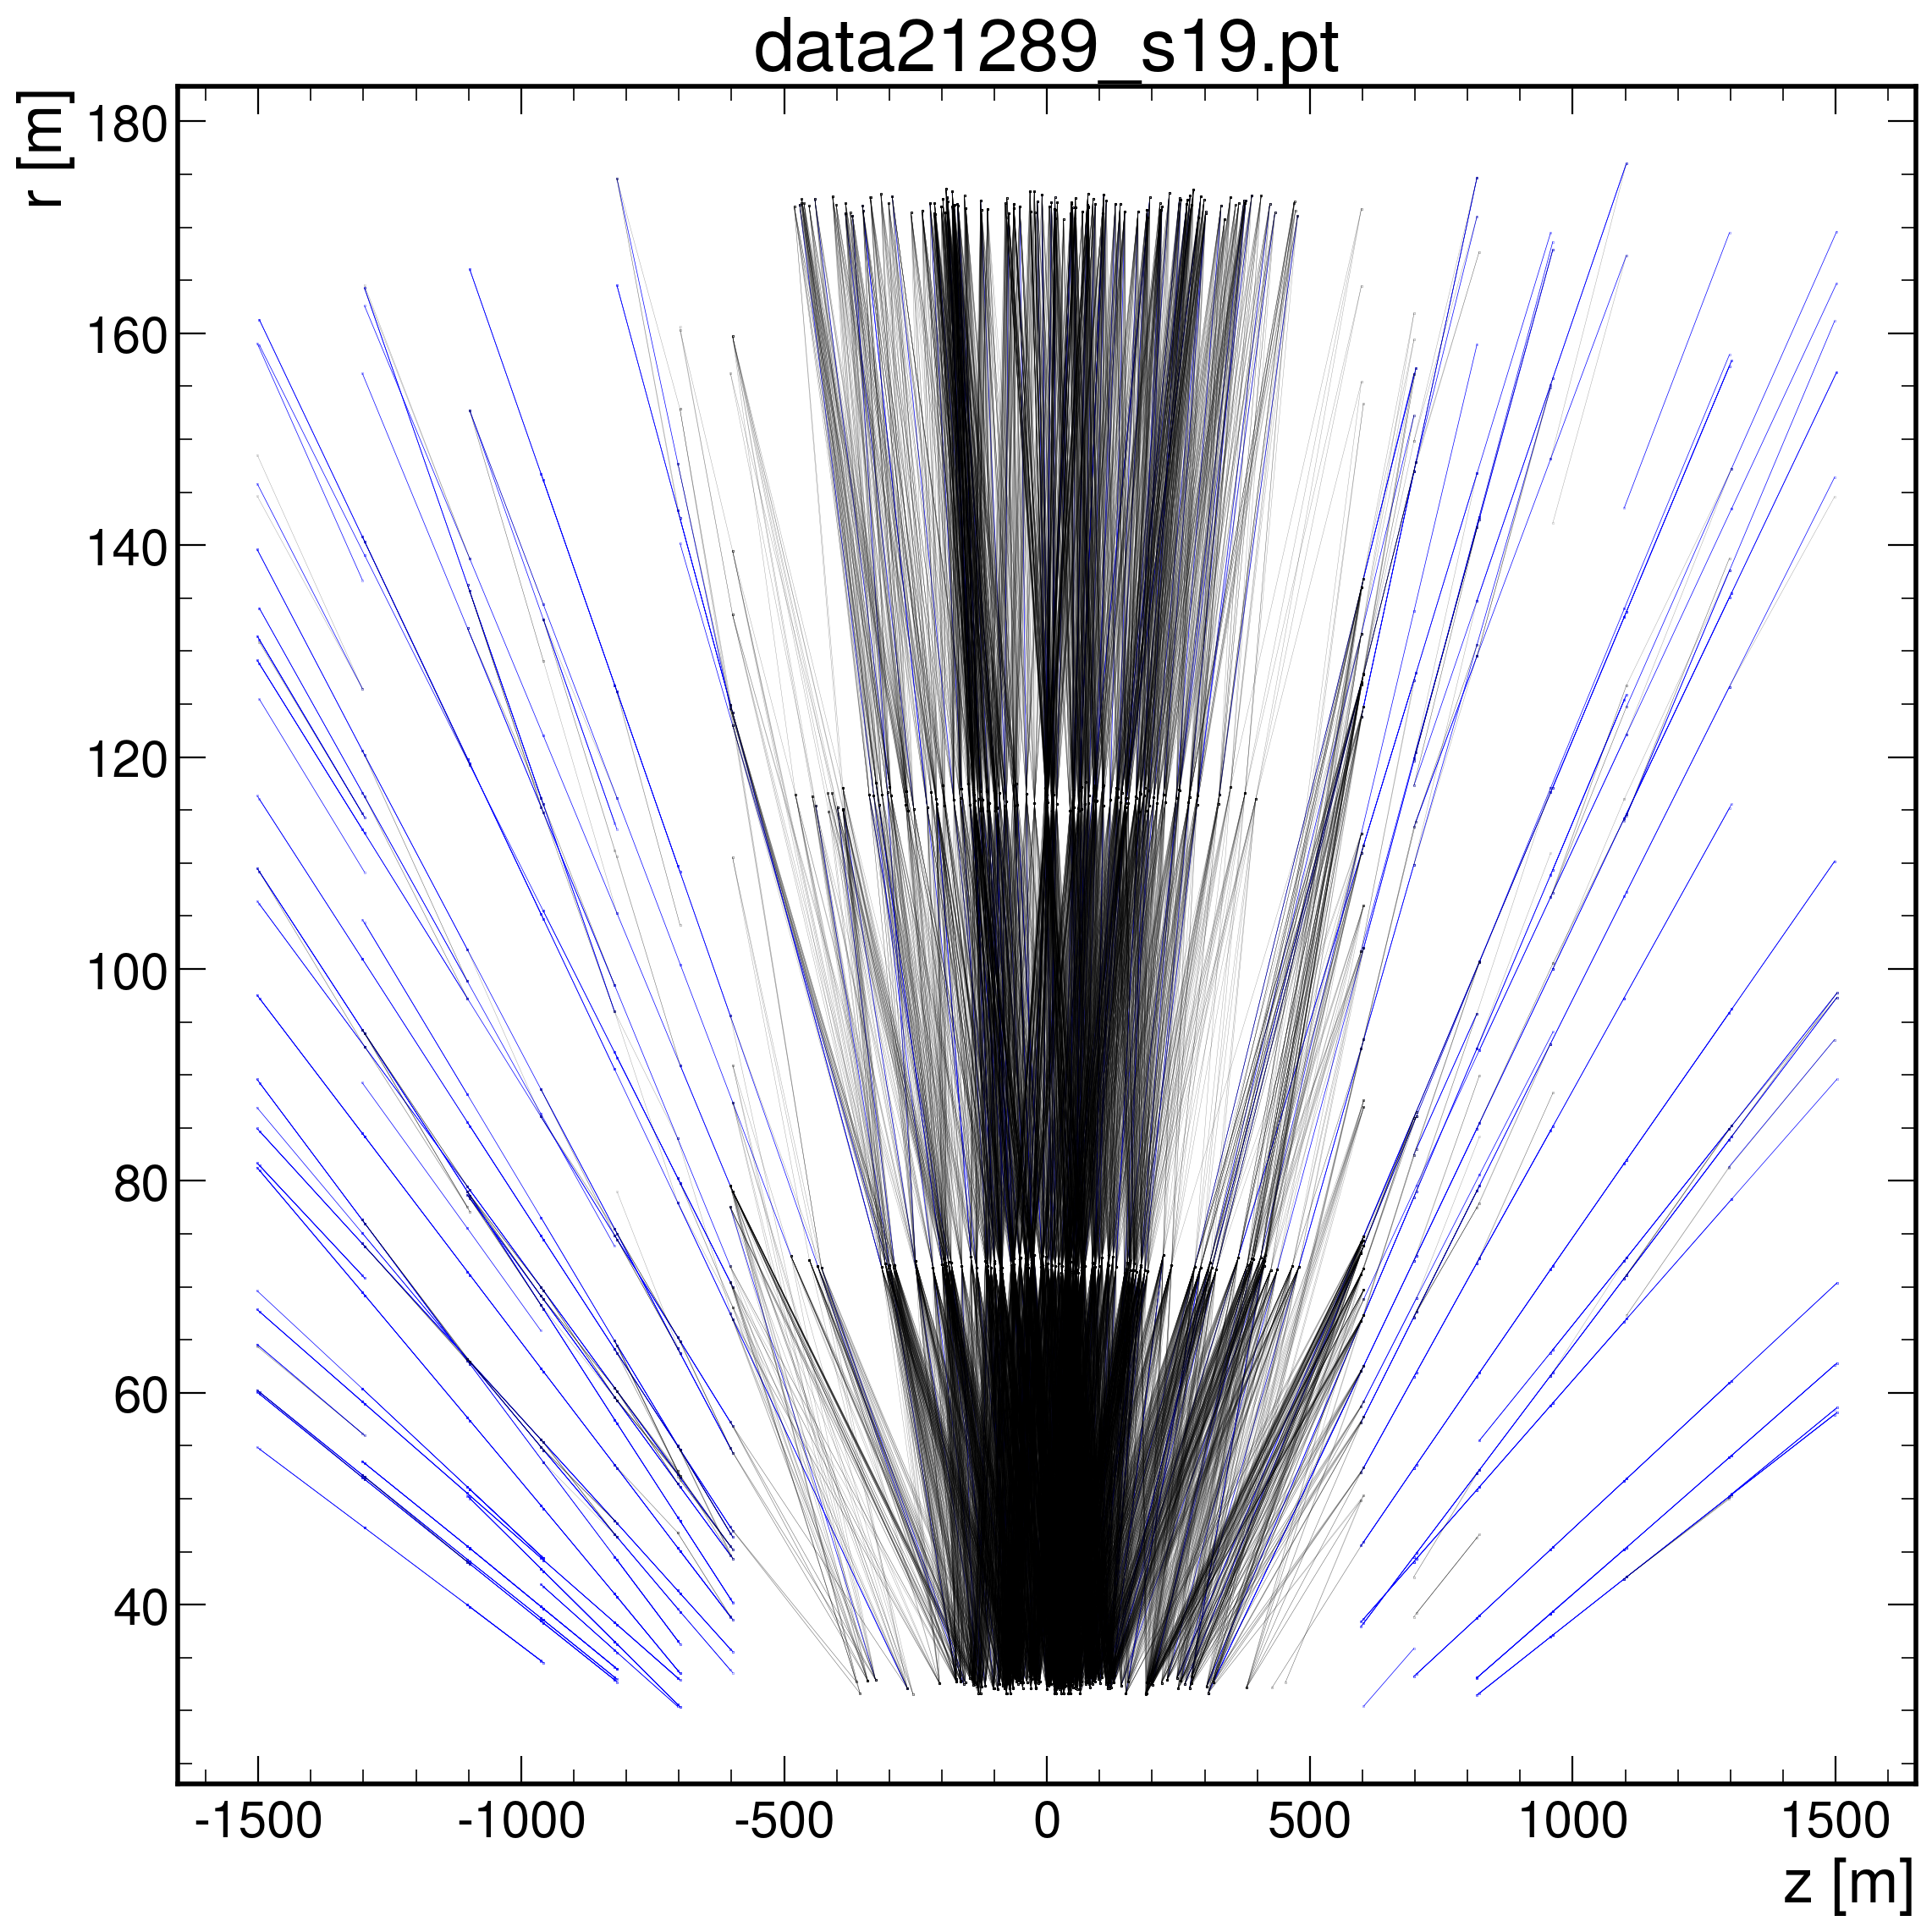

In [12]:
import numpy as np
from torch_geometric.data import Data
from matplotlib import pyplot as plt
import mplhep as hep
hep.style.use("CMS")

class GraphPlotter():
    def __init__(self, style='seaborn-paper'):
        self.style=style
        
    def configure_plt(self):
        plt.style.use(self.style)
        rcParams.update({'figure.autolayout': True})

    def plot_rz(self, graph: Data, name: str, 
                scale=np.array([1,1,1]), savefig=False):
        x = graph.x[:,:3] / scale
        y = graph.y
        edge_index = graph.edge_index
        feats_o = x[edge_index[0,:]]
        feats_i = x[edge_index[1,:]]
        true_edges_o = feats_o[y>0.5]
        true_edges_i = feats_i[y>0.5]
        false_edges_o = feats_o[y<0.5]
        false_edges_i = feats_i[y<0.5]
        
        fig, ax = plt.subplots(dpi=200, figsize=(12,12))
        for i in range(len(true_edges_o)):
            ax.plot(
                (true_edges_o[i][2], true_edges_i[i][2]),
                (true_edges_o[i][0], true_edges_i[i][0]),
                marker="o",
                ls="-",
                color="blue",
                lw=0.25,
                ms=0.1,
                alpha=1,
            )
        for i in range(len(false_edges_o)):
            ax.plot(
                (false_edges_o[i][2], false_edges_i[i][2]),
                (false_edges_o[i][0], false_edges_i[i][0]),
                marker="o",
                ls="-",
                color="black",
                lw=0.15,
                ms=0.1,
                alpha=0.4,
            )
            
        ax.set_ylabel("r [m]")
        ax.set_xlabel("z [m]")
        plt.title(name)
        if savefig:
            plt.savefig(filename, dpi=1200)
        plt.tight_layout()
        plt.show()

        
g = GraphPlotter()
for k, v in graph_builder.data_list.items():
    g.plot_rz(v, k)
    break
    